## LOAD DATA & Lib

In [ ]:
import os
import sys
from pathlib import Path

project_root = Path.cwd().resolve().parents[1]   
sys.path.append(str(project_root / "src"))

import math
import random
import pickle

from collections import deque, namedtuple
from typing import List, Tuple
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym
from lime import lime_tabular

from cartpole.qnet import DQN, predict, rebuild_model

In [ ]:
# model 
rebuild_model_path = '../cartpole/model/cartpole_dqn_best.pth'
model = rebuild_model(rebuild_model_path, 4, 2)

In [150]:
# DATA
with open('../cartpole/snapshots/cartpole_state_snapshots.pkl', 'rb') as f:
	state_snapshots = pickle.load(f)

with open('../cartpole/snapshots/cartpole_failure_snapshots.pkl', 'rb') as f:
	failure_snapshots = pickle.load(f)

## Lime 

1. local 현상을 해석하고자 함  
2. 간단한 회귀모형이나 트리 모형으로 행동을 해석하고자 함 

강화학습에서 LIME  
(s,a), Q(s,a) = 

In [ ]:
ENV_ID = "CartPole-v1"
SEED = 42
EPISODES = 500
MAX_STEPS = 500
REPLAY_CAPACITY = 10000
BATCH_SIZE = 64
GAMMA = 0.99
LR = 1e-3
TARGET_SYNC = 200       
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 4000        

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

### Set Env, Agent 
env = gym.make(ENV_ID)
env.action_space.seed(SEED)
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]  # 4: [x, x_dot, theta, theta_dot]

In [102]:
# =========================
# 5) LIME로 특정 행동 설명
# =========================

FEATURE_NAMES = ["cart_pos", "cart_vel", "pole_angle", "pole_ang_vel"]


def make_lime_explainer(train_states: np.ndarray) -> lime_tabular.LimeTabularExplainer:
    # LIME은 주변 분포를 학습 데이터 통계로 가정하고 perturbation을 샘플링합니다.
    # continuous features → mode='regression'
    return lime_tabular.LimeTabularExplainer(
        training_data=train_states,
        feature_names=FEATURE_NAMES,
        mode="regression",
        discretize_continuous=False # 연속형 그대로 사용(해석이 더 자연스러움)
    )

def q_predict_for_action(X: np.ndarray, action_idx: int) -> np.ndarray:
	# LIME에서 타겟값으로 사용할 q값을 반환하는 함수 
    with torch.no_grad():
        s = torch.tensor(X, dtype=torch.float32, device=DEVICE)
        q = model(s)  # (N, n_actions)
        return q[:, action_idx].detach().cpu().numpy()


def explain_one_state_action(state: np.ndarray, action_idx: int, explainer: lime_tabular.LimeTabularExplainer):
    """
    state에서 'action_idx'의 Q(s, a_idx)를 타겟으로 LIME local surrogate를 학습/시각화.
    HTML 파일을 저장하고, 콘솔에도 중요도 요약을 출력합니다.
    """

    predict_fn = lambda X: q_predict_for_action(X, action_idx)
    exp = explainer.explain_instance(
        data_row=state,
        predict_fn=predict_fn,
        num_features=4,       # 상위 중요도 4개 표시 (CartPole은 4차원)
        num_samples=5000      # 주변 샘플 수 (증가시키면 더 안정)
    )

    # 콘솔 요약 출력 
    print("\n[LIME Explanation] for Q(s, a={})".format(action_idx))
    for fname, weight in exp.as_list():
        print(f"  {fname:>20s} : {weight:+.4f}")


    # HTML 저장
    html_path = "lime_explanation_cartpole.html"
    exp.save_to_file(html_path)
    print(f"\n📄 Saved LIME HTML to: {html_path} (브라우저로 열어서 확인하세요)")

    # exp.local_pred, exp.score 등의 수치도 확인 가능
    print(f"Local predicted Q(s,a): {float(exp.local_pred):.4f} | R^2 of local surrogate: {float(exp.score):.3f}")

def pick_state_and_action_for_explain() -> Tuple[np.ndarray, int]:
    """
    평가 에피소드를 한 번 돌며, 정책이 argmax Q로 선택한 시점의 (state, action)를 하나 픽업.
    """
    state, _ = env.reset(seed=SEED + 999)

    for t in range(200):
        with torch.no_grad():
            q = model(torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0))
            action = int(q.argmax(dim=1).item())

        # 해당 시점의 state/action을 리턴
        return state.copy(), action

    return state.copy(), action

In [103]:
train_states = np.array(state_snapshots, dtype=np.float32)
explainer = make_lime_explainer(train_states)

# 설명할 (s, a*) 하나 고르기
state, a_chosen = pick_state_and_action_for_explain()
print(f"\nExplain this state (first 4 dims): {state}")
print(f"Chosen action by policy(argmax Q): {a_chosen}")

# LIME로 Q(s, a_chosen) 설명
explain_one_state_action(state, a_chosen, explainer)


Explain this state (first 4 dims): [ 0.04014554 -0.00983761  0.03838552 -0.00567072]
Chosen action by policy(argmax Q): 1

[LIME Explanation] for Q(s, a=1)
              cart_vel : -1.4349
          pole_ang_vel : -1.0041
            pole_angle : -0.8075
              cart_pos : +0.0160

📄 Saved LIME HTML to: lime_explanation_cartpole.html (브라우저로 열어서 확인하세요)
Local predicted Q(s,a): 107.9733 | R^2 of local surrogate: 0.086


/var/folders/zl/ljg24f_15m93w7f2rt14c2n80000gn/T/ipykernel_70148/2315516066.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Local predicted Q(s,a): {float(exp.local_pred):.4f} | R^2 of local surrogate: {float(exp.score):.3f}")


In [88]:
def lime_weights(explainer, state, action_idx, num_features=4, num_samples=2048):
    """LIME으로 Q(s, a_idx)를 로컬 선형 근사하고 (이름, 가중치, 실제값) 리스트 반환"""
    predict_fn = lambda X: q_predict_for_action(X, action_idx)
    exp = explainer.explain_instance(
        data_row=state,
        predict_fn=predict_fn,
        num_features=num_features,
        num_samples=num_samples
    )
    # exp.as_list() → [(feature_name, weight), ...]
    pairs = exp.as_list()
    names  = [p[0].split(' <= ')[0].split(' > ')[0] for p in pairs]  # 구간화 안쓰면 그대로 이름
    weights = [p[1] for p in pairs]
    # 선택된 feature들의 실제 state 값 (표시용)
    # FEATURE_NAMES와 매칭
    name_to_idx = {n:i for i,n in enumerate(FEATURE_NAMES)}
    values = [state[name_to_idx[n]] if n in name_to_idx else np.nan for n in names]
    return names, weights, values, float(exp.local_pred), float(exp.score)

def plot_lime_bar(ax, names, weights, values, title):
    """가중치 부호에 따라 색을 달리해 수평 막대 그래프 그리기"""
    y = np.arange(len(names))
    colors = ['tab:orange' if w >= 0 else 'tab:blue' for w in weights]
    ax.barh(y, weights, align='center', color=colors, alpha=0.9)
    ax.set_yticks(y, labels=names)
    ax.invert_yaxis()
    ax.set_xlabel('LIME weight (local contribution to Q)')
    ax.set_title(title, pad=10)
    # 값 주석
    for i, (w, v) in enumerate(zip(weights, values)):
        ax.text(w + (0.02 if w>=0 else -0.02), i, f"{v:+.2f}",
                va='center', ha='left' if w>=0 else 'right', fontsize=9)
    ax.axvline(0, color='black', linewidth=1, alpha=0.6)
    ax.grid(axis='x', linestyle=':', alpha=0.3)

def visualize_cartpole_state(state, ax=None):
    """
    state = [cart_pos, cart_vel, pole_angle, pole_ang_vel]
    """
    cart_pos, cart_vel, pole_angle, pole_ang_vel = state
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,3))

    # 기본 배경
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-0.5, 1.5)
    ax.axhline(0, color="black", linewidth=1)

    # 수레 (cart)
    cart_width, cart_height = 0.3, 0.2
    cart = plt.Rectangle((cart_pos - cart_width/2, 0),
                         cart_width, cart_height,
                         color="tab:blue", alpha=0.7)
    ax.add_patch(cart)

    # 막대 (pole)
    pole_length = 1.0
    x_tip = cart_pos + pole_length * np.sin(pole_angle)
    y_tip = cart_height + pole_length * np.cos(pole_angle)
    ax.plot([cart_pos, x_tip], [cart_height, y_tip],
            color="tab:red", linewidth=3)

    # 각도 표시
    ax.text(-2.3, 1.3, f"pole_angle = {np.degrees(pole_angle):.1f}°", fontsize=10)
    ax.text(-2.3, 1.1, f"cart_pos   = {cart_pos:+.2f}", fontsize=10)
    ax.text(-2.3, 0.9, f"cart_vel   = {cart_vel:+.2f}", fontsize=10)
    ax.text(-2.3, 0.7, f"pole_ang_vel = {np.degrees(pole_ang_vel):+.1f}°/s", fontsize=10)
    ax.set_aspect('equal')
    ax.axis('off')

    if ax is None:
        plt.show()
	
def explain_compare_actions(state, explainer, actions=(0,1)):
    """동일한 state에서 행동 0/1의 Q를 각각 LIME으로 설명해 좌우 병렬로 표시"""
    fig, axs = plt.subplots(1, len(actions)+1, figsize=(18, 5), sharey=True)
    visualize_cartpole_state(state, ax=axs[-1])
    if len(actions) == 1:
        axs = [axs]
    for ax, a in zip(axs, actions):
        names, weights, values, local_q, r2 = lime_weights(explainer, state, a)
        plot_lime_bar(ax, names, weights, values, title=f"Action {a}  |  Q≈{local_q:.2f}, R²={r2:.2f}")
	
    fig.suptitle("LIME explanations for Q(s, a) by action", y=1.03, fontsize=12)
    plt.tight_layout()
    plt.show()

**막대** : $\text{contribution}_i = w_i \cdot z^’_i$로 Q값에 영향을 준 기여도 정도 

In [151]:
failure_snapshots = np.array(failure_snapshots, dtype=np.float32)

9


/var/folders/zl/ljg24f_15m93w7f2rt14c2n80000gn/T/ipykernel_70148/1405405047.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return names, weights, values, float(exp.local_pred), float(exp.score)
/var/folders/zl/ljg24f_15m93w7f2rt14c2n80000gn/T/ipykernel_70148/1405405047.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return names, weights, values, float(exp.local_pred), float(exp.score)


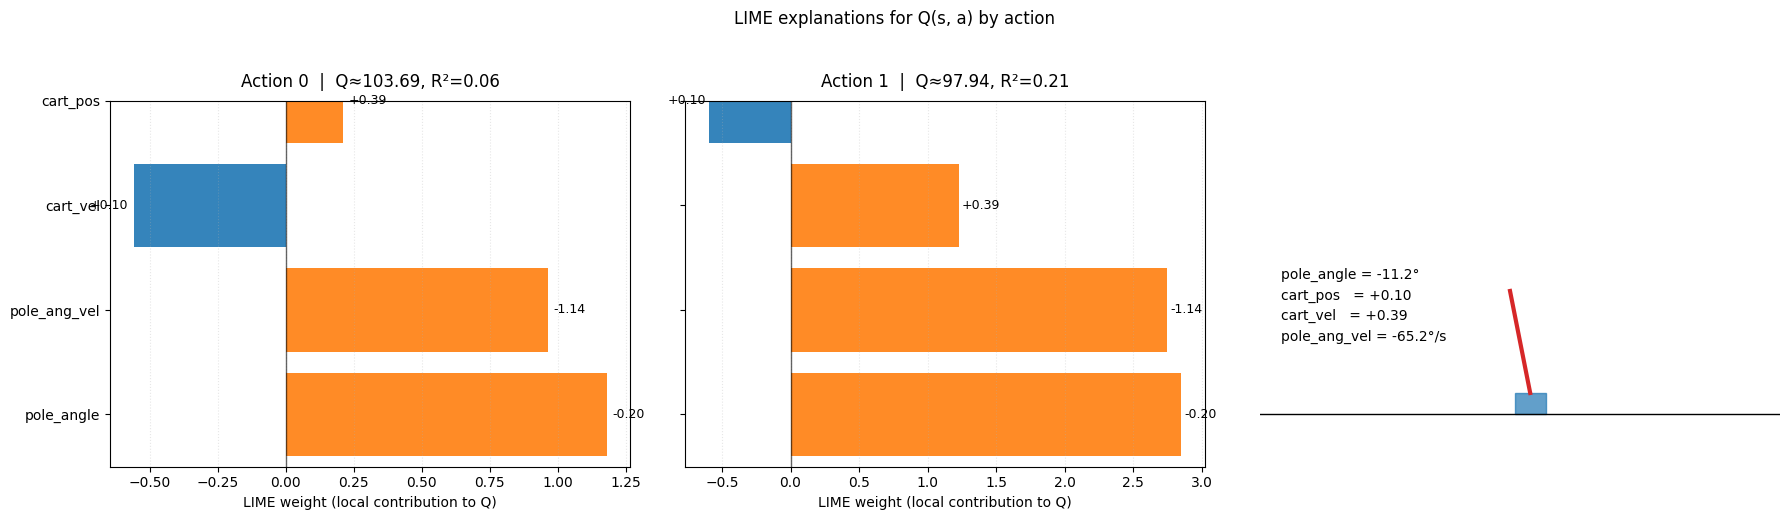

In [162]:
# 병렬 비교: 행동 0과 1을 동시에 플롯 (HTML 저장 X)
# idx = random.randint(0, len(train_states)-1)
# idx = 5695
# idx = 9358
# idx = 4207
idx = 9
print(idx)
# sample_state = train_states[idx]
sample_state = failure_snapshots[idx]
explain_compare_actions(sample_state, explainer, actions=(0,1))

In [ ]:
def generate_lime_animation(env, explainer, model, num_steps=50, save_path="lime_cartpole.mp4"):
    """
    LIME + CartPole 상태 변화를 동시에 애니메이션으로 저장
    """
    state, _ = env.reset(seed=0)
    frames = []
    fig, axs = plt.subplots(1, 2, figsize=(10,6))
    plt.tight_layout()

    # 애니메이션용 업데이트 함수
    def update(frame_idx):
        nonlocal state
        axs[0].cla()
        axs[1].cla()

        # 모델의 행동 선택
        with torch.no_grad():
            q = model(torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0))
            action = int(q.argmax(dim=1).item())
            q_value = q[0, action].item()

        # LIME 해석
        names, weights, values, local_q, r2 = lime_weights(explainer, state, action_idx=action)

        # 왼쪽: CartPole 상태 시각화
        visualize_cartpole_state(state, ax=axs[0])
        axs[0].set_title(f"Step {frame_idx} | Action {action} | Q≈{local_q:.1f}")

        # 오른쪽: LIME 바차트
        plot_lime_bar(axs[1], names, weights, values, title=f"LIME (R²={r2:.2f})")

        # 환경 진행
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        if done or truncated:
            state, _ = env.reset()
        return axs

    anim = FuncAnimation(fig, update, frames=num_steps, interval=250, repeat=False)
    anim.save(save_path, fps=4, dpi=120)
    print(f"🎞️ Saved LIME animation → {save_path}")
    plt.close(fig)

generate_lime_animation(env, explainer, model, num_steps=100, save_path="lime_cartpole.mp4")

/var/folders/zl/ljg24f_15m93w7f2rt14c2n80000gn/T/ipykernel_70148/1405405047.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return names, weights, values, float(exp.local_pred), float(exp.score)
/var/folders/zl/ljg24f_15m93w7f2rt14c2n80000gn/T/ipykernel_70148/1405405047.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return names, weights, values, float(exp.local_pred), float(exp.score)
/var/folders/zl/ljg24f_15m93w7f2rt14c2n80000gn/T/ipykernel_70148/1405405047.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array b

🎞️ Saved LIME animation → lime_cartpole.mp4



막대가 왼쪽으로 기울었을 때 -> pole_angle이 음수(weight < 0)  

왼쪽 기울기는 Q를 낮추는 요인 → 즉 불안정 신호   

막대가 왼쪽으로 기울어도 막대가 오른쪽으로 돌아오는 중일 때 -> pole_ang_vel이 양수(weight > 0)  
복원 중 → 현재 행동이 안정화 방향임  

수레가 오른쪽에 있고 왼쪽으로 움직일 때 -> cart_pos는 양수(+), cart_vel은 음수(−)  
위치는 복원에 도움, 속도는 불안정 요소  

안정된 상태(거의 중앙)  
모든 weight 절댓값이 작음  
상태가 안정적이므로 행동이 결과에 큰 영향 안 줌  


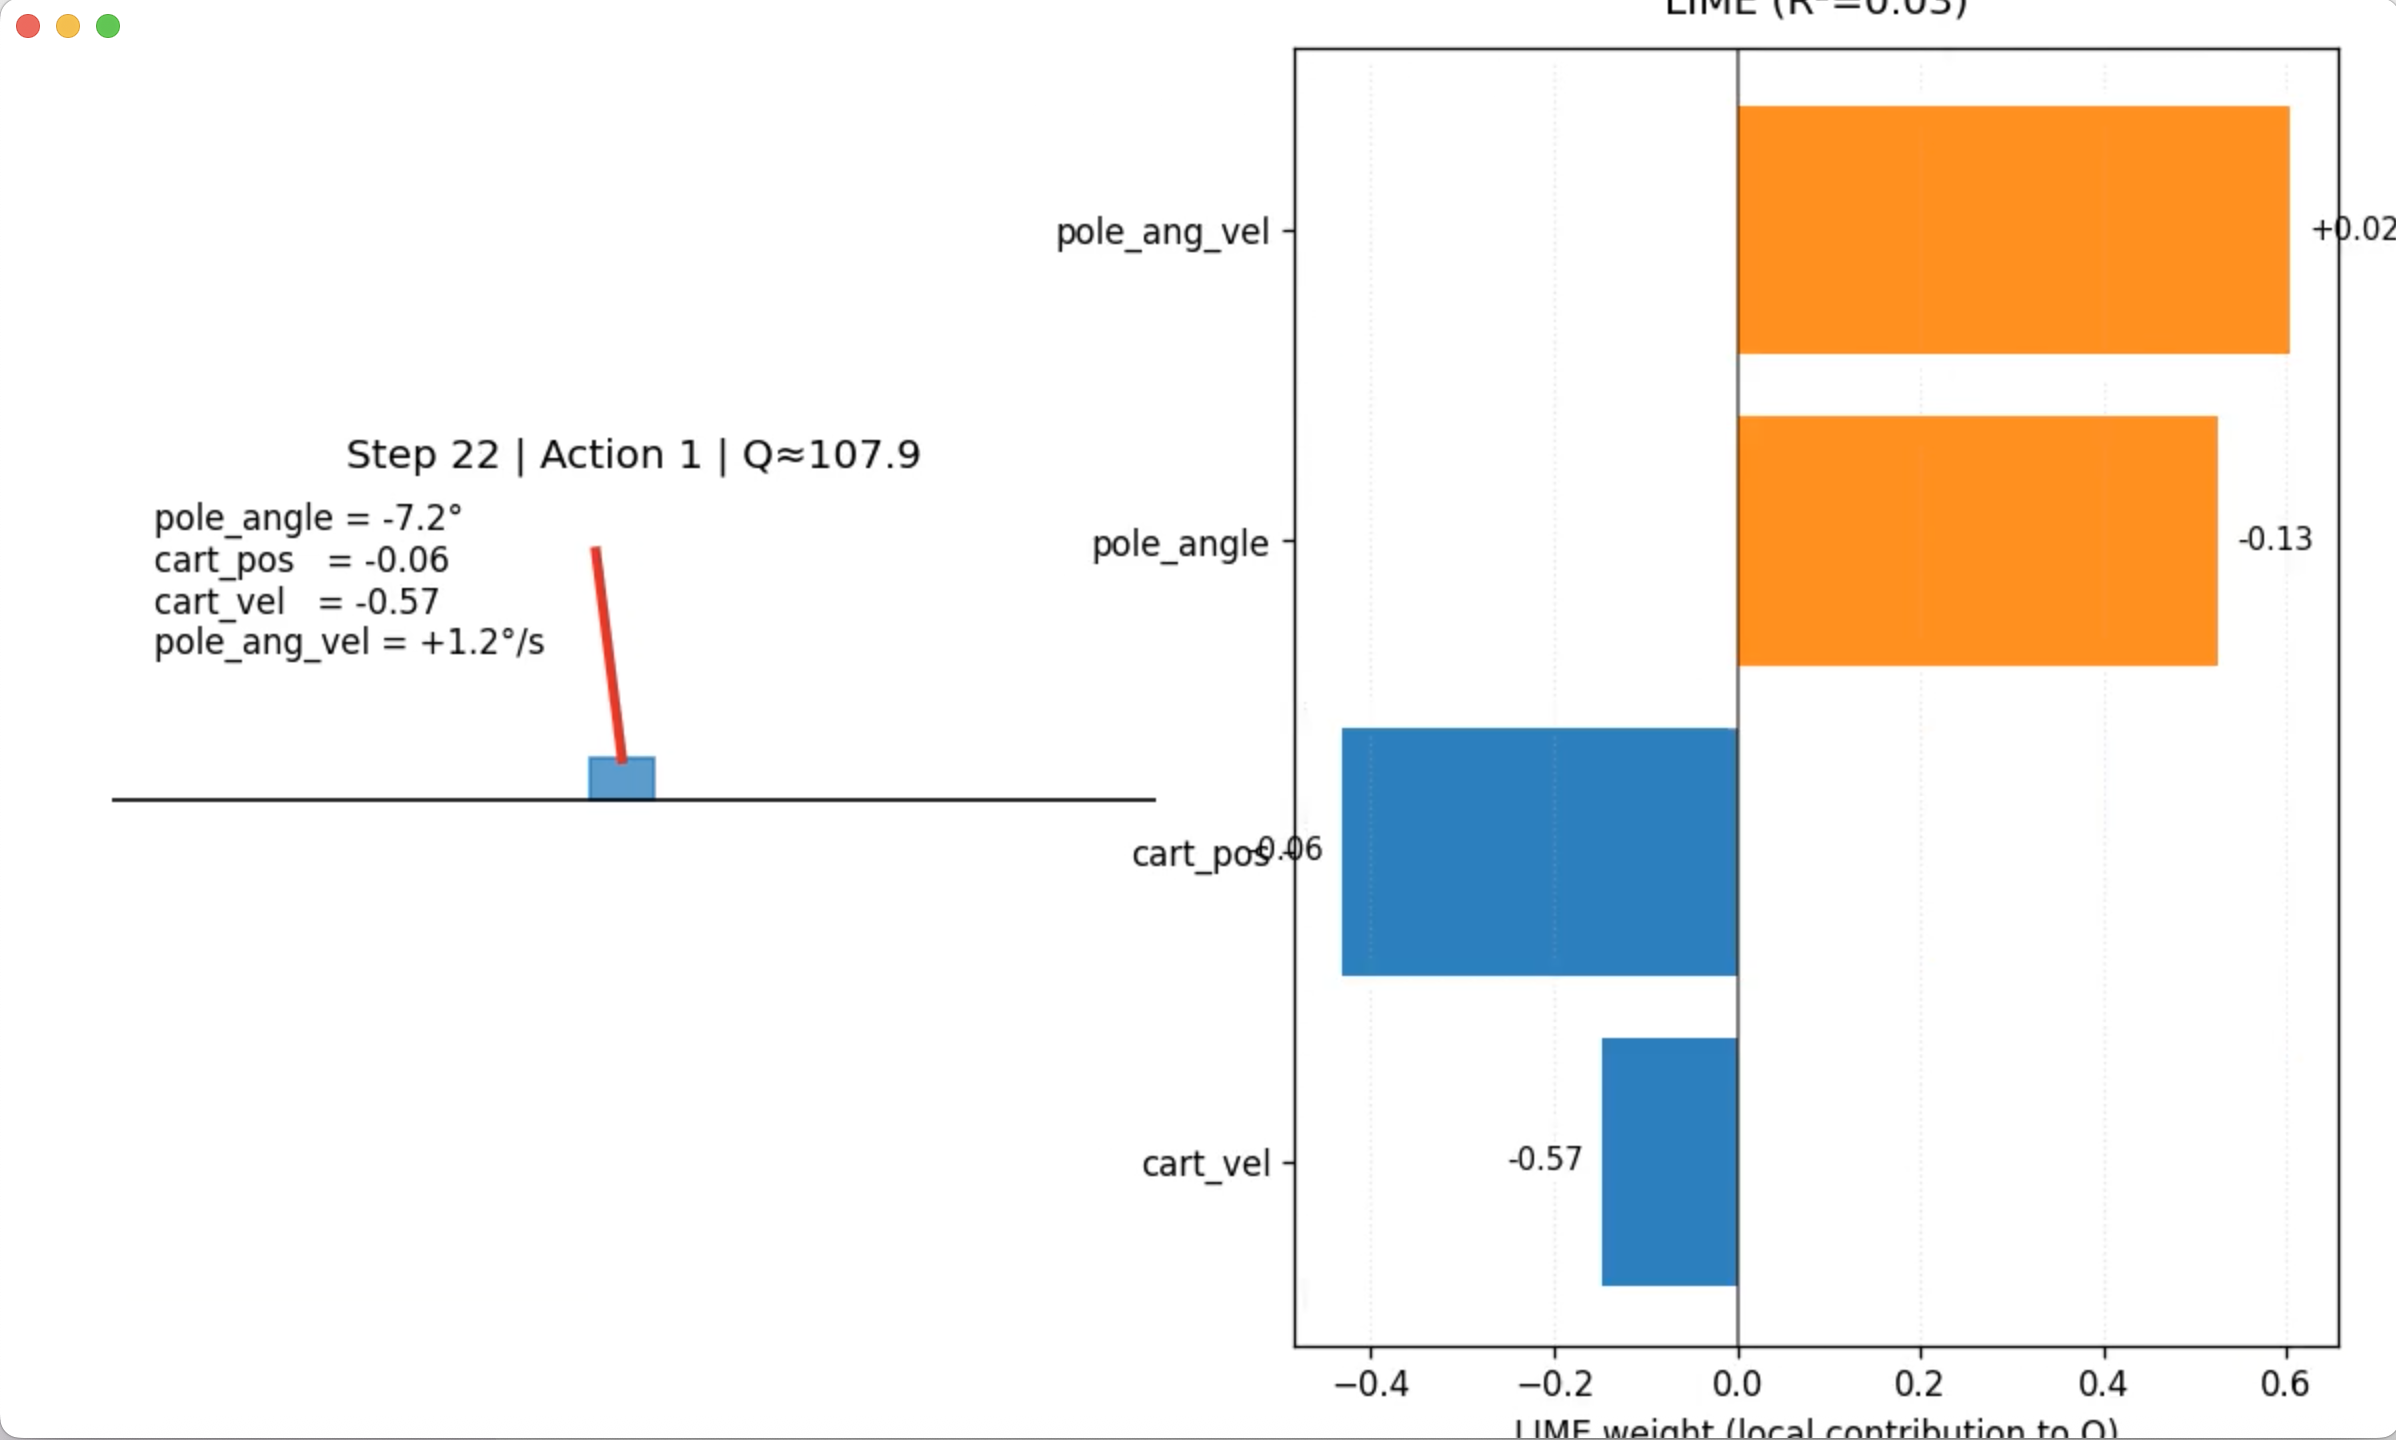

행동이 1(오른쪽) : 막대를 오른쪽으로 이동하는 속도를 높여줌, 이미 왼쪽으로 기울어져 있는 것을 회복하는데 힘이 많이 듦 -> 인과관계가 나타남 
